# Small Worlds and Large Worlds

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import altair as alt
import scipy.stats as stats

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## The Garden of Forking Data

### 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways/ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## Building a Model

## Components of the Model

### 2.2

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

## Making the Model Go

It's simpler to define a function for code blocks 2.3 to 2.5

In [5]:
def grid_approx(prior, n, k):
    """
    updates a binomial likelihood given n, k and a prior.
    granularity is the length of the prior
    """
    p_grid = np.linspace(0, 1, len(prior))
    likelihood = stats.binom.pmf(k, n=n, p=p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    data = pd.DataFrame({"x": p_grid,
                         "p(x)": posterior})
    return data

### 2.3 - 2.4

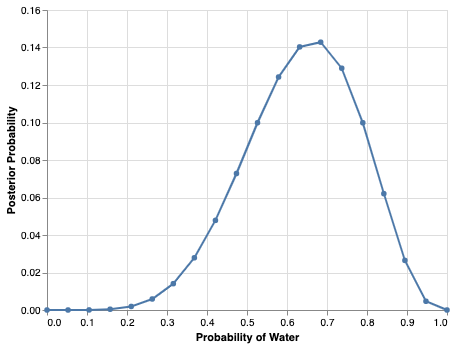

In [6]:
prior = np.repeat(1, 20)
source = grid_approx(prior, 9, 6)
(alt
 .Chart(source)
 .mark_line(point=True)
 .encode(x=alt.X("x", title='Probability of Water'), 
         y=alt.Y("p(x)", title="Posterior Probability")))

### 2.5

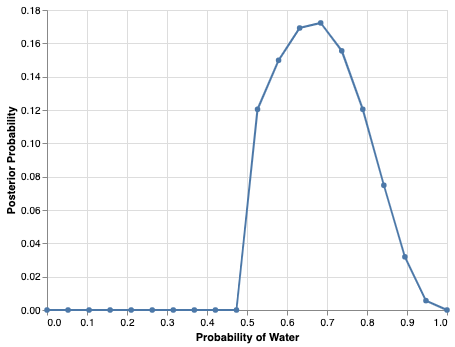

In [7]:
prior = np.where(np.linspace(0, 1, 20) < 0.5, 0, 1)
source = grid_approx(prior, 9, 6)
(alt
 .Chart(source)
 .mark_line(point=True)
 .encode(x=alt.X("x", title='Probability of Water'), 
         y=alt.Y("p(x)", title="Posterior Probability")))

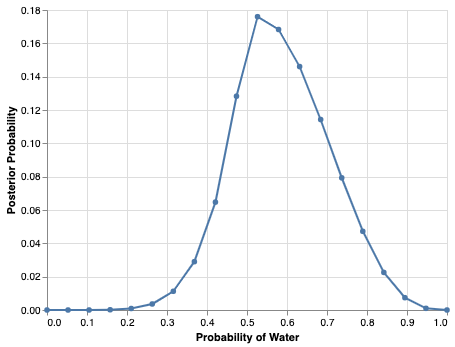

In [8]:
prior = np.exp(-5*np.abs(np.linspace(0, 1, 20) - 0.5))
source = grid_approx(prior, 9, 6)
(alt
 .Chart(source)
 .mark_line(point=True)
 .encode(x=alt.X("x", title='Probability of Water'), 
         y=alt.Y("p(x)", title="Posterior Probability")))

### 2.6

In [9]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=9, p=p, observed=6)
    mean_q = pm.find_MAP()
    hess_q = pm.find_hessian(mean_q, vars=[p])
    std_q = (1/hess_q[0, 0])**0.5
mean_q["p"], std_q

(array(0.66666667), 0.15713484014616183)

In [10]:
norm = stats.norm(mean_q["p"], std_q)
prob = 0.89
norm.ppf([(1-prob)/2, (1+prob)/2])

array([0.41553484, 0.91779849])

### 2.7

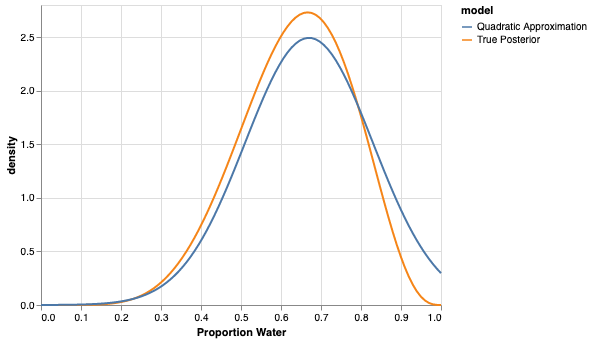

In [11]:
w = 6
n = 9
xs = np.linspace(0, 1, 100)
beta = stats.beta.pdf(xs, w+1, n-w+1)
norm = stats.norm.pdf(xs, 0.67, 0.16)
source = pd.concat([pd.DataFrame({"xs": xs,
                                  "density": beta,
                                  "model": "True Posterior"}),
                    pd.DataFrame({"xs": xs,
                                  "density": norm,
                                  "model": "Quadratic Approximation"})])
(alt
 .Chart(source)
 .mark_line()
 .encode(x=alt.X('xs', title="Proportion Water"),
         y="density",
         color="model"))

### 2.8

In [12]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(loc=p[i-1], scale=0.1).rvs(1)[0]
    if p_new < 0:
        p_new = np.abs(p_new)
    elif p_new > 1:
        p_new = 2 - p_new
        
    q0 = stats.binom.pmf(W, W+L, p[i-1])
    q1 = stats.binom.pmf(W, W+L, p_new)
    p[i] = p_new if stats.uniform().rvs(1)[0] < q1/q0 else p[i-1]

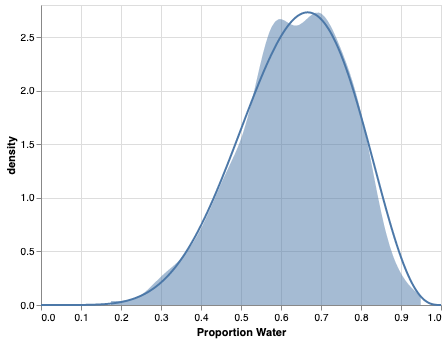

In [13]:
xs = np.linspace(0, 1, 1000)
beta = stats.beta(W+1, L+1).pdf(xs)
source = pd.DataFrame({"xs": xs,
                       "density": beta})
line_chart = (alt
              .Chart(source)
              .mark_line()
              .encode(x=alt.X('xs', title="Proportion Water"),
                      y="density"))

source = pd.DataFrame({"samples": p})
dens_chart = (alt
              .Chart(source)              
              .transform_density('samples',
                                 as_=['samples', 'density'])
              .mark_line()
              .mark_area(opacity=0.5)
              .encode(x="samples:Q",
                      y='density:Q')
              .properties(title=''))

line_chart + dens_chart